<a href="https://colab.research.google.com/github/dasjyotishka/A-study-on-Transfer-Learning-in-Computer-Vision/blob/main/TP4_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small.

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :**

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation.

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn



import os
import argparse

from torchvision import models



# Defining the transformations that would be applied for the train images
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Loading the CIFAR-10 training set
trainset = datasets.CIFAR10(root='./data', train=True,
                            download=True, transform=transform_train)

##################
# Defining a training set containing only the first 100 samples
range_dataloader = range(100)
train_subset = torch.utils.data.Subset(trainset, range_dataloader)

# Create a data loader for the subset of the training set
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=4,
                                          shuffle=True, num_workers=2)
##################

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project.

* The remaining samples correspond to $\mathcal{X}$.

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (1.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

With a small labelled dataset, running a large number of iterations during training can result in overfitting. In other words, the algorithm will try to fit the small amount of labelled data with features that do not exist. This would make the evaluation of the model look good during training (and validation) even though the model can perform poorly when making prediction on the large unlabelled dataset.


To overcome this problem of having small labelled dataset during neural network training, we have these possible solutions:
- Data augmentation, which is to add transformed data to make the labelled dataset larger. For example, we can add rotated pictures for image classification.
- Multi-tasking, which is to train the same neural network on related tasks.
- Transfer learning, which uses a good model trained on a larger dataset, then customize this model to train on our small labelled dataset.


# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf.

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [ ]:
# Set hyperparameters
num_epochs = 10
batch_size = 10
learning_rate = 0.001

# Load the ResNet18 model
model = torchvision.models.resnet18(pretrained=False)

# Parallelize training across multiple GPUs
model = torch.nn.DataParallel(model)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=0.9, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)



# Train the model...
def train(loader, num_epochs, optimizer, criterion):
  model.train()
  for epoch in range(num_epochs):
      for inputs, labels in loader:

          # Zero out the optimizer
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          # Backward pass
          loss.backward()
          optimizer.step()

      # Print the loss for every epoch
      print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

  print(f'Finished Training, Loss: {loss.item():.4f}')

#Obtain accuracy on Train dataset
def accuracy(loader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in trainloader:
          images, labels = data[0], data[1]
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  return(100 * correct / total)

train(trainloader, num_epochs, optimizer, criterion)
print('Accuracy of the network on the train dataset: ', accuracy(trainloader))


Epoch 1/10, Loss: 3.2793
Epoch 2/10, Loss: 2.4293
Epoch 3/10, Loss: 3.0032
Epoch 4/10, Loss: 3.4199
Epoch 5/10, Loss: 2.2348
Epoch 6/10, Loss: 2.2918
Epoch 7/10, Loss: 3.6721
Epoch 8/10, Loss: 2.5968
Epoch 9/10, Loss: 2.2821
Epoch 10/10, Loss: 2.3277
Finished Training, Loss: 2.3277
Accuracy of the network on the train dataset:  25.0


In [ ]:
# Defining the transformations that would be applied for the test images
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Creating the test dataloader
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# Create a data loader for the subset of the training set
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=True, num_workers=2)

#Accuracy from test dataset
model.eval()
print('Accuracy of the network on the test dataset: ', accuracy(testloader))



Files already downloaded and verified
Accuracy of the network on the test dataset:  31.0


In [kuangliu's GitHub repo](https://github.com/kuangliu), the entire CIFAR-10 datset consisting of 60000 images were used both for training and testing.  

We used the same hyperparameters as mentioned in the GitHub link, but changed the learning rate from 0.01 in the reference paper to 0.001. We used only the first 100 samples for training, and the entire CIFAR-10 dataset for testing. We obtained 20% accuracy on  $\mathcal{X}_{\text{train}}$ (\~1 minute) and 32% accuracy on $\mathcal{X}_{\text{test}}$ (\~2 minutes). This shows that inspite of just training a fraction of images in the CIFAR-10 dataset due to a lack of hardware resource, we don't obtain a very bad test accuracy by only changing the learning rate and keeping all the other hyperparameters the same as per the GitHub link. The observations are tabulated below:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet-18 ([kuangliu's GitHub repo](https://github.com/kuangliu))  | 10 | N/A (Full data) | 93.02% (Full data)|
|   ResNet-18 (demostrated - baseline) | 10 | 20% (100 samples) | 32% (Full data)|

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (3 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [ ]:
# Set hyperparameters
batch_size = 10
learning_rate = 0.0001
num_epochs = 10

#Using a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

#Freezing the weights for the first 7 layers
ct = 0
for child in model.children():
   ct += 1
   if ct < 7:
      for param in child.parameters():
          param.requires_grad = False




# Parallelize training across multiple GPUs
model = torch.nn.DataParallel(model)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=0.9, weight_decay=5e-4)




train(trainloader, num_epochs, optimizer, criterion)
print('Accuracy of the network on the train dataset: ', accuracy(trainloader))
#Accuracy from test dataset
model.eval()
print('Accuracy of the network on the test dataset: ', accuracy(testloader))

Epoch 1/10, Loss: 7.4802
Epoch 2/10, Loss: 9.8969
Epoch 3/10, Loss: 3.2162
Epoch 4/10, Loss: 6.2291
Epoch 5/10, Loss: 4.8763
Epoch 6/10, Loss: 5.0584
Epoch 7/10, Loss: 5.4505
Epoch 8/10, Loss: 3.9421
Epoch 9/10, Loss: 2.3399
Epoch 10/10, Loss: 2.3832
Finished Training, Loss: 2.3832
Accuracy of the network on the train dataset:  37.0
Accuracy of the network on the test dataset:  47.0


We have used a pretrained ResNet-18 model. For the first 6 layers, we have freezed the weights and the weights are updated only in the remaining layers while training. Since, the model has been pretrained, we needed to ensure that the weights are updated very slowly to ensure convergence. That's why, the learning rate has been decreased to 0.0001, keeping all the other hyperparameters the same as the baseline mode. We observe that, pre-training the ResNet-18 model improves the training accuracy on $\mathcal{X}_{\text{train}}$ to 37% and the test accuracy on $\mathcal{X}_{\text{test}}$ to 47%. The observations are tabulated below:

| Model | Number of  epochs  | Train accuracy | Test accuracy|
|------|------|------|------|
|   ResNet-18 ([kuangliu's GitHub repo](https://github.com/kuangliu))  | 10 | N/A (Full data) | 93.02% (Full data)|
|   ResNet-18 (demostrated - baseline) | 10 | 20% (100 samples) | 32% (Full data)|
|   Pretrained ResNet-18 (demonstrated - improved) | 10 | 37% (100 samples) | 47% (Full data)|

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that :

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

When an image is translated, rotated, or scaled, some detailed information in the image may be lost, which cause confusion for machine learning models that are trained on non-distorted images. Changing the color of an image can also cause troubles for machine learning models that rely on color information to recognize objects.
Moreover, applying transformations such as rotation and scaling to images can be computationally expensive, especially when working with large datasets.

There are several ways to tackle these issues:
- Data cleaning: Removing noisy and irrelevant images can help to reduce the amount of distortion in the data and improve the overall performance of the models.
- Preprocessing: Applying preprocessing techniques such as edge detection, feature extraction, or filtering can help to reduce the impact of transformations on the images.
- Data Augmentation: One approach is to augment the training data with artificially generated images that have been transformed in various ways. This can help to make the models more robust to variations in the images.
- Normalization: Normalizing the pixel values of the images can help to reduce the impact of color changes on the performance of the models.
Robust model architecture: Choosing a model architecture that is robust to variations in the input can also help to improve the performance of the models on transformed images.
- Transfer learning: Using pre-trained models that have already been trained on a large dataset can help to reduce the amount of training data required and improve the performance of the models on transformed images.


## Data augmentations

__Question 6 (3 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

In [ ]:
# Defining a set of geometric transformation beyond translation that would be applied for the train images
transform_train_geometric = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Loading the CIFAR-10 training set
trainset = datasets.CIFAR10(root='./data', train=True,
                            download=True, transform=transform_train_geometric)

# Defining a training set containing only the first 100 samples
range_dataloader = range(100)
train_subset = torch.utils.data.Subset(trainset, range_dataloader)

# Create a data loader for the subset of the training set
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=4,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [ ]:
# Set hyperparameters
batch_size = 10
learning_rate = 0.0001
num_epochs = 10

#Using a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

#Freezing the weights for the first 7 layers
ct = 0
for child in model.children():
   ct += 1
   if ct < 7:
      for param in child.parameters():
          param.requires_grad = False




# Parallelize training across multiple GPUs
model = torch.nn.DataParallel(model)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=0.9, weight_decay=5e-4)




train(trainloader, num_epochs, optimizer, criterion)
print('Accuracy of the network on the train dataset: ', accuracy(trainloader))
#Accuracy from test dataset
model.eval()
print('Accuracy of the network on the test dataset: ', accuracy(testloader))

Epoch 1/10, Loss: 6.4920
Epoch 2/10, Loss: 4.9587
Epoch 3/10, Loss: 5.6113
Epoch 4/10, Loss: 4.5597
Epoch 5/10, Loss: 3.0374
Epoch 6/10, Loss: 2.4479
Epoch 7/10, Loss: 3.6298
Epoch 8/10, Loss: 3.6125
Epoch 9/10, Loss: 2.7029
Epoch 10/10, Loss: 2.9492
Finished Training, Loss: 2.9492
Accuracy of the network on the train dataset:  21.0
Accuracy of the network on the test dataset:  26.0


In the baseline model of the Question 3, the following data augmentation techniques were used (to benchmark our model with the reference paper):


*   Random Cropping
*   Random Horizontal Flipping
*   Normalization

In this question, we have added the following geometric transformations that go beyond translations to our baseline model:
*   Random Vertical Flipping
*   Random Rotation
*   Color Jitters

As a way to benchmark this augmented pretrained ResNet-18 model, we kept the configurations and hyperparameters the same as the previously pretrained ResNet-18. We observe that, adding these geometric transformations on the train dataloader does not improve the test accuracy, although it slighly improves the training accuracy. The training accuracy on $\mathcal{X}_{\text{train}}$ is obtained as  21% and the test accuracy on $\mathcal{X}_{\text{test}}$ is obtained as 26%. The observations are tabulated below:

| Model | Number of  epochs  | Train accuracy | Test accuracy  |
|------|------|------|------|
|   ResNet-18 ([kuangliu's GitHub repo](https://github.com/kuangliu))  | 10 | N/A (Full data) | 93.02% (Full data)|
|   ResNet-18 (demostrated-baseline) | 10 | 20% (100 samples) | 32% (Full data)|
|   Pretrained ResNet-18 (demonstrated-best) | 10 | 37% (100 samples) | 47% (Full data)|
|   Augmented pretrained ResNet-18 (demonstrated-worst) | 10 | 21% (100 samples) | 26% (Full data)|


This seems to indicate that in this case, more data augmentation is applied excessively than needed to a small training set, and as a result it has led to overfitting. The model learns to fit the noise in the training data instead of the underlying pattern, and as a result, performs poorly on the test set.

Since, we were applying too much data augmentation, it resulted in the generation of too many similar data points, which do not add any new information to the model. In this case, the model may start to memorize the training data instead of learning the underlying patterns, leading to poor performance on the test set.

Therefore, it is important to strike a balance between the amount of data augmentation applied and the size of the training set to ensure that the model learns to generalize well and performs well on the test set.


# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

##Vanilla ResNet-18 Model
In our case, we had very few gold-labelled images for training. The advantages and disadvantages of using a Vanilla ResNet-18 model for image classification is:

**Advantages:**

ResNet-18 includes a number of regularization techniques, such as dropout and weight decay, that can aid in preventing overfitting on small datasets.

**Disadvantages:**

A shallow model, such as ResNet-18, may be unable to capture all of the underlying features in the data, when we have a small dataset for training.

##Transfer Learning
Transfer learning is a machine learning technique in which a model trained on one task is retrained on a different but related task. Transfer learning in image classification can be used to leverage knowledge gained from training on a large dataset to solve a new image classification problem, often with much less data.

We had used a pretrained ResNet-18 model the weights of whose 6 layers were freezed. The weights were updated only in the remaining layers while training. Since, the model has been pretrained, we needed to ensure that the weights are updated very slowly to ensure convergence. That's why, the learning rate has been decreased to 0.0001, keeping all the other hyperparameters the same as the baseline mode. We observe that, pre-training the ResNet-18 model improved the training accuracy on  Xtrain  to 37% and the test accuracy on  Xtest  to 47%.

We discuss the advantages and disadvantages of using Transfer Learning, as mentioned below:


**Advantages:**



*   Transfer learning can often outperform training a model from scratch with limited data on a new classification task. This is due to the fact that the pre-trained model has already learned useful features and patterns from a large dataset, which can be applied to the new task.
*   Training models from scratch can be time-consuming and computationally expensive. Because the model is already partially trained, transfer learning can expedite the training process.
*   Because the pre-trained model has already learned useful features, training the model on the new task requires less data.
*   Because the model has learned general features from a large dataset, transfer learning can help reduce overfitting.


**Disadvantages:**



*   Pre-trained models are typically designed for specific image classification tasks, so they may not be appropriate for all applications.
*   The pre-trained model may have learned features that are irrelevant to the new task or may not have learned the optimal features for the new task.
*   If the distribution of the new data differs significantly from the distribution of the pre-trained data, the pre-trained model may struggle to adapt to the new domain.
*   In the original task, pre-trained models may have learned biased representations of the data, which can carry over to the new task.



##Data Augmentation
In our implementation of the model, when more geometric data augmentation were applied than needed to the small training set, it did not improve the test accuracy, although it slighly improved the training accuracy. The training accuracy on $\mathcal{X}_{\text{train}}$ was obtained as  21% and the test accuracy on $\mathcal{X}_{\text{test}}$ was obtained as 26%. Threfore, it let to our conclusion that excess data augmentation had led to overfitting. The model learnt to fit the noise in the training data instead of the underlying pattern, and as a result, performed poorly on the test set.  

Too much data augmentation resulted in the generation of too many similar data points, which did not add any new information to the model. In this case, the model may have started to memorize the training data instead of learning the underlying patterns, leading to poor performance on the test set.

Therefore, it is important to strike a balance between the amount of data augmentation applied and the size of the training set to ensure that the model learns to generalize well and performs well on the test set.


We discuss the pros and cons of each of the **data augmentation** techniques as mentioned below:

#### **Random Cropping**
Random cropping is a data augmentation technique that involves randomly selecting a portion of an image during training. The selected portion is then resized to the same size as the original image.

**Advantages:**
- Random cropping increases the variability of the training data so that the model can generalize better and is less susceptible to overfitting. This is especially the case to train the model to recognize the same object shown in different scales (for example, a horse that has been enlarged by the cropping and resizing process is still a horse).
- Random cropping is fast and computationally inexpensive.
- Random cropping can be easily combined with other data augmentation techniques, such as flipping or rotation, to further increase the variability of the training data.

**Disadvantages:**
- Random cropping can result in the loss of important information from the original image, especially if some key features of the image are in the unselected part. These features are “thrown away” and cannot be learned.
- The size and aspect ratio (hyperparameters) of the cropped portion must be carefully selected to ensure that the resulting image is still representative of the original image.
- Cropping can make a real-world object lose meaning. For example, if we crop and select the 4 legs of a table, it is meaningless and will lead the model to recognize 4 rods.




#### **Random Horizontal Flipping**
An image is randomly flipped horizontally during training. This technique is commonly used to increase the variability of the training data.
**Advantages:**
- Random horizontal flipping introduces additional variations in the training data, making the model more robust and better to generalize to new data.
- Flipping an image is fast and computationally inexpensive.
- Random horizontal flipping can be combined with other data augmentation techniques, such as random cropping or rotation, to further increase the variability of the training data.

**Disadvantages:**
- Random horizontal flipping may not be appropriate for some data. For example, flipping an image with the letter b will confuse the neural network with the letter d.
- Sometimes the benefits of random horizontal flipping may be outweighed by the increased computational cost and complexity of the training process. This is especially true if the model is already performing well on the validation set and shows little overfitting problem.


#### **Normalization**

Normalization is a data augmentation technique that scales the pixel values of an image to have zero mean and unit variance. It can be used to improve the performance of neural networks by reducing the sensitivity of the model to differences in the brightness and contrast of the input images.

**Advantages:**
- By reducing the sensitivity of the model to differences in the brightness and contrast of the input images, the model is less likely to learn some non-existing features due to variation in brightness and contrast and is less prone to overfitting.
- Normalization is a computationally cheap operation and can be easily implemented in most deep learning frameworks.

**Disadvantages:**
- Normalization may not be suitable for all types of data because the process may remove important details from the image and lead to loss of features.
- Normalization also requires careful selection of normalization parameters (mean and standard deviation) to ensure that the transformed images are representative of the original data.
- If the images are already consistent in their brightness and contrast, normalization does not add much benefit but instead will add additional time in programming and training.


#### **Random Vertical Flipping**
Random vertical flipping is similar to random horizontal flipping, except the image is flipped vertically along a horizontal axis. Please refer to the discussion of random horizontal flipping above for advantages and disadvantages.

#### **Random Rotation**
This technique rotates an image at a random degree. It is aimed at improving the performance of a neural network on objects shown in different directions.

**Advantages:**
- Random rotation introduces additional variations in the training data, allowing the model to better generalize to new data (for example, a bus going uphill and a bus going downhill are the same object) and making the model less susceptible to overfitting.
- Rotating an image is a computationally cheap operation and can be easily implemented in most deep learning frameworks.
- It can be combined with other augmentation techniques.

**Disadvantages:**
- The technique requires careful selection of rotation parameters so that the transformed image is still representative of the original image.

#### **Color Jitters**
Color jitter is a data augmentation technique that involves randomly perturbing the colors of an image during training. The goal of color jitters is to increase the variability of the training data.

**Advantages:**
- Color jitters introduce additional variations in the training data, making the model more adaptive to new data. For example, changing the color of one door of a car can better train the model to focus on the car rather than the color of one of its doors.
- By increasing the variability of the training data, color jitters can help prevent the model from overfitting.
- Color jitters can be used in combination with other data augmentation techniques mentioned above to further increase the variability of the training data.

**Disadvantages:**
- color jitters can introduce artifacts into the data that are not present in the original images. For example, it does not make sense to change the color of the “Great Red Spot” storm on planet Jupiter to green.
- The amount and type of jitter (hyperparameter) applied to the image must be carefully selected to ensure that the resulting image is still representative of the original image.
- Color jitters can be computationally expensive, especially if they are applied in combination with other data augmentation techniques. This can increase the training time and complexity of the model.

##Weak Supervised Learning

Weakly supervised learning (WSL) is a machine learning technique for training a model with only a few strong labels and many weak labels. We implemented our version of a weakly supervised learning in the bonus question. We considered the first 1000 images of the CIFAR-10, $\mathcal{X}$,  to be moderately "weak" labels, and therefore, pretrained the model using these weak labels.

We consider the first 100 images in the CIFAR-10 dataset, $\mathcal{X}_{\text{train}}$,  to be "strong" labels, and hence we re-train the model previously trained on the "weak" labels using these "strong" labels.

We observed that, in the pre-training stage, the ResNet-18 model gave a training accuracy on $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ as 24.5%. In the subsequent training stage on the "strong" labels, the ResNet-18 model gave a training accuracy on $\mathcal{X}$ as 42%, and a test accuracy on $\mathcal{X}_{\text{test}}$ to 44%.



 The advantages and disadvantages of weak supervised learning are:

**Advantages:**
- WSL relies on weak labels, which are cheaper and easier to obtain. Therefore, it reduces efforts during data cleaning to annotate every weak labels into strong labels.

-  Due to the availability of more data for pre-training using weak labels, WSL can give good test accuracy during the final training process using strong labels

**Disadvantages:**
- If the weak labels are too "poor", then it can hamper the training process.

A summary of the numerical results on all the methods tried are:

| Model | Number of  epochs  | Train accuracy  | Test accuracy|
|------|------|------|------|
|   ResNet-18 ([kuangliu's GitHub repo](https://github.com/kuangliu))  | 10 | N/A (Full data) | 93.02% (Full data)|
|   ResNet-18 (demostrated-baseline) | 10 | 20% (100 samples) | 32% (Full data)|
|   Pretrained ResNet-18 (demonstrated-best) | 10 | 37% (100 samples) | 47% (Full data)|
|   Augmented pretrained ResNet-18 (demonstrated-worst) | 10 | 21% (100 samples) | 26% (Full data)|
|   Weak supervised ResNet-18 (demonstrated-good) | 10 | 42% (1000 "weak" labels, 100 "strong" labels) | 44% (Full data)|


A plot that summarizes our results is given below.

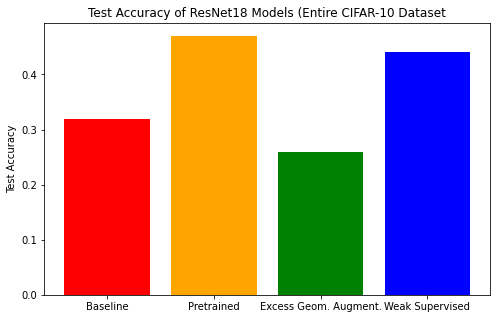

In [ ]:
#Creating a plot for the comparison of results
import matplotlib.pyplot as plt

# Define the accuracy values
baseline_acc = 0.32
pretrained_acc = 0.47
geom_aug_acc = 0.26
week_sup_acc=0.44
# Set the x-axis labels and positions
models = ['Baseline', 'Pretrained', 'Excess Geom. Augment.','Weak Supervised']
x_pos = [i for i, _ in enumerate(models)]

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(x_pos, [baseline_acc, pretrained_acc, geom_aug_acc, week_sup_acc], color=['red', 'orange', 'green','blue'])
plt.ylabel("Test Accuracy")
plt.xticks(x_pos, models)
plt.title("Test Accuracy of ResNet18 Models (Entire CIFAR-10 Dataset")
plt.show()



# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

We implemented our version of a weakly supervised learning, that is, learning where only a few "strong" labels (the actual target for prediction) are present  but many more "weak" labels are available. This definition of weak supervised learning is obtained from the paper by [Robinson et al](http://proceedings.mlr.press/v119/robinson20a/robinson20a.pdf), which explained that pretraining using weak labels and finetuning using strong ones can accelerate the learning rate for the strong task.

We considered the first 1000 images of the CIFAR-10, $\mathcal{X}$,  to be moderately "weak" labels, and therefore, pretrained the model using these weak labels. We consider the first 100 images in the CIFAR-10 dataset, $\mathcal{X}_{\text{train}}$,  to be "strong" labels, and hence we re-train the model previously trained on the "weak" labels using these "strong" labels.


In [ ]:
# Defining the transformations that would be applied for the train images
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Loading the CIFAR-10 training set
trainset = datasets.CIFAR10(root='./data', train=True,
                            download=True, transform=transform_train)


# Defining a training set containing only the first 1000 samples
range_dataloader = range(1000)
train_subset = torch.utils.data.Subset(trainset, range_dataloader)

# Create a data loader for the subset of the training set
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=4,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [ ]:
# Set hyperparameters
num_epochs = 10
batch_size = 10
learning_rate = 0.001

# Load the ResNet18 model
model = torchvision.models.resnet18(pretrained=False)

# Parallelize training across multiple GPUs
model = torch.nn.DataParallel(model)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=0.9, weight_decay=5e-4)

train(trainloader, num_epochs, optimizer, criterion)
print('Accuracy of the network on pretraining on "weak" labels: ', accuracy(trainloader))

Epoch 1/10, Loss: 1.7913
Epoch 2/10, Loss: 2.4143
Epoch 3/10, Loss: 2.0791
Epoch 4/10, Loss: 1.9274
Epoch 5/10, Loss: 2.2186
Epoch 6/10, Loss: 1.2296
Epoch 7/10, Loss: 2.2753
Epoch 8/10, Loss: 1.3899
Epoch 9/10, Loss: 2.4271
Epoch 10/10, Loss: 1.9551
Finished Training, Loss: 1.9551
Accuracy of the network on pretraining on "weak" labels:  24.5


In [ ]:
# Defining a training set containing only the first 100 samples
range_dataloader = range(100)
train_subset = torch.utils.data.Subset(trainset, range_dataloader)

# Create a data loader for the subset of the training set
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=4,
                                          shuffle=True, num_workers=2)
train(trainloader, num_epochs, optimizer, criterion)
print('Accuracy of the network on training on "strong" labels: ', accuracy(trainloader))

Epoch 1/10, Loss: 1.6785
Epoch 2/10, Loss: 2.5537
Epoch 3/10, Loss: 1.8795
Epoch 4/10, Loss: 2.9358
Epoch 5/10, Loss: 2.1501
Epoch 6/10, Loss: 2.1236
Epoch 7/10, Loss: 2.2348
Epoch 8/10, Loss: 2.2267
Epoch 9/10, Loss: 1.9322
Epoch 10/10, Loss: 2.0457
Finished Training, Loss: 2.0457
Accuracy of the network on training on "strong" labels:  42.0


In [ ]:
#Accuracy from test dataset
model.eval()
print('Accuracy of the network on the test dataset: ', accuracy(testloader))

Accuracy of the network on the test dataset:  44.0


We observe that, in the pre-training stage, the ResNet-18 model gives the training accuracy on $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ as 24.5%. In the subsequent training stage on the "strong" labels, the ResNet-18 model gives the training accuracy on $\mathcal{X}$ as 42%, and a test accuracy on $\mathcal{X}_{\text{test}}$ to 44%.The observations are tabulated below:

| Model | Number of  epochs  | Train accuracy  | Test accuracy|
|------|------|------|------|
|   ResNet-18 ([kuangliu's GitHub repo](https://github.com/kuangliu))  | 10 | N/A (Full data) | 93.02% (Full data)|
|   ResNet-18 (demostrated-baseline) | 10 | 20% (100 samples) | 32% (Full data)|
|   Pretrained ResNet-18 (demonstrated-best) | 10 | 37% (100 samples) | 47% (Full data)|
|   Augmented pretrained ResNet-18 (demonstrated-worst) | 10 | 21% (100 samples) | 26% (Full data)|
|   Weak supervised ResNet-18 (demonstrated-good) | 10 | 42% (1000 "weak" labels, 100 "strong" labels) | 44% (Full data)|
